In [61]:
library(tidyverse)
library(tidymodels)
library("GGally")
library(stringr)
library(repr)

# Proposal Group 17: Title....

Lua Presidio, Daniel ..., Michelle ...

Data credit: 

## Introdution

somethign something


## Preliminary exploratory data analysis

In [62]:
fire_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)
nrow(fire_data)


fire_data2  <- fire_data %>%
    mutate(seq = 1:nrow(fire_data)) %>%
    mutate(Region = case_when(seq < 123 ~ "Bejaia",
                              TRUE ~ "Sidi-Bel Abbes"))

fire_data_fix <- fire_data2 %>%
    filter(seq == 168) %>%
    separate(col = "DC", into = c("DC", "new"), sep = " ") %>%
    mutate(Classes = FWI)%>%
    mutate(FWI = BUI) %>%
    mutate(BUI = ISI) %>%
    mutate(ISI = new) %>%
    select(-new)
    

fire_data2 <- fire_data2[-c(123,124, 168), ] 
nrow(fire_data2)

fire_data_comp <- rbind(fire_data2, fire_data_fix)

numerics <- c("day", "month", "year", "Temperature", "RH", "Ws", "Rain", "FFMC", "DMC", "DC", "ISI", "BUI", "FWI")

fire_data_comp <- select(fire_data_comp, -seq) %>%
    mutate(seq = 1:nrow(fire_data_comp)) %>%
    type.convert(as.is = TRUE)
fire_data_comp
    
set.seed(10)
fire_data_split <- initial_split(fire_data_comp, prop = 0.75, strata = Classes)
fire_data_training <- training(fire_data_split)
fire_data_testing <- testing(fire_data_split)
    
    
    

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


[1] 246

[1] 243

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region,seq
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia,1
2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia,2
3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia,3
4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia,4
5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia,5
6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire,Bejaia,6
7,6,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,Bejaia,7
8,6,2012,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire,Bejaia,8
9,6,2012,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire,Bejaia,9


We choose a 75/25 split for the training/testing data because our data set only has 244 rows, which is a fairly low number of observations, so we want sufficient number of observations to train on. 

In [63]:
fire_data_training %>%
    select(-(day:year), -(FFMC:BUI), seq, -RH) %>%
    group_by(Classes, Region) %>%
    summarize(Temperature_avg = mean(Temperature),
              Ws_avg = mean(Ws),
              Rain_avg = mean(Rain),
              FWI_avg = mean(FWI),
             n = n())



`summarise()` regrouping output by 'Classes' (override with `.groups` argument)



Classes,Region,Temperature_avg,Ws_avg,Rain_avg,FWI_avg,n
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
fire,Bejaia,32.83333,15.68750,0.01458333,10.8270833,48
fire,Sidi-Bel Abbes,34.17857,14.80357,0.20892857,11.7000000,56
not fire,Bejaia,29.95652,16.71739,1.64130435,1.0586957,46
not fire,Sidi-Bel Abbes,30.08824,15.00000,1.85294118,0.7911765,34


This table shows the mean values of the Temperature, Wind speed, Rain (in mm) and the Fire Weather Index for each region and whether there was a fire or not. It also displays the number of observations where there is a fire/not a fire for each Region.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



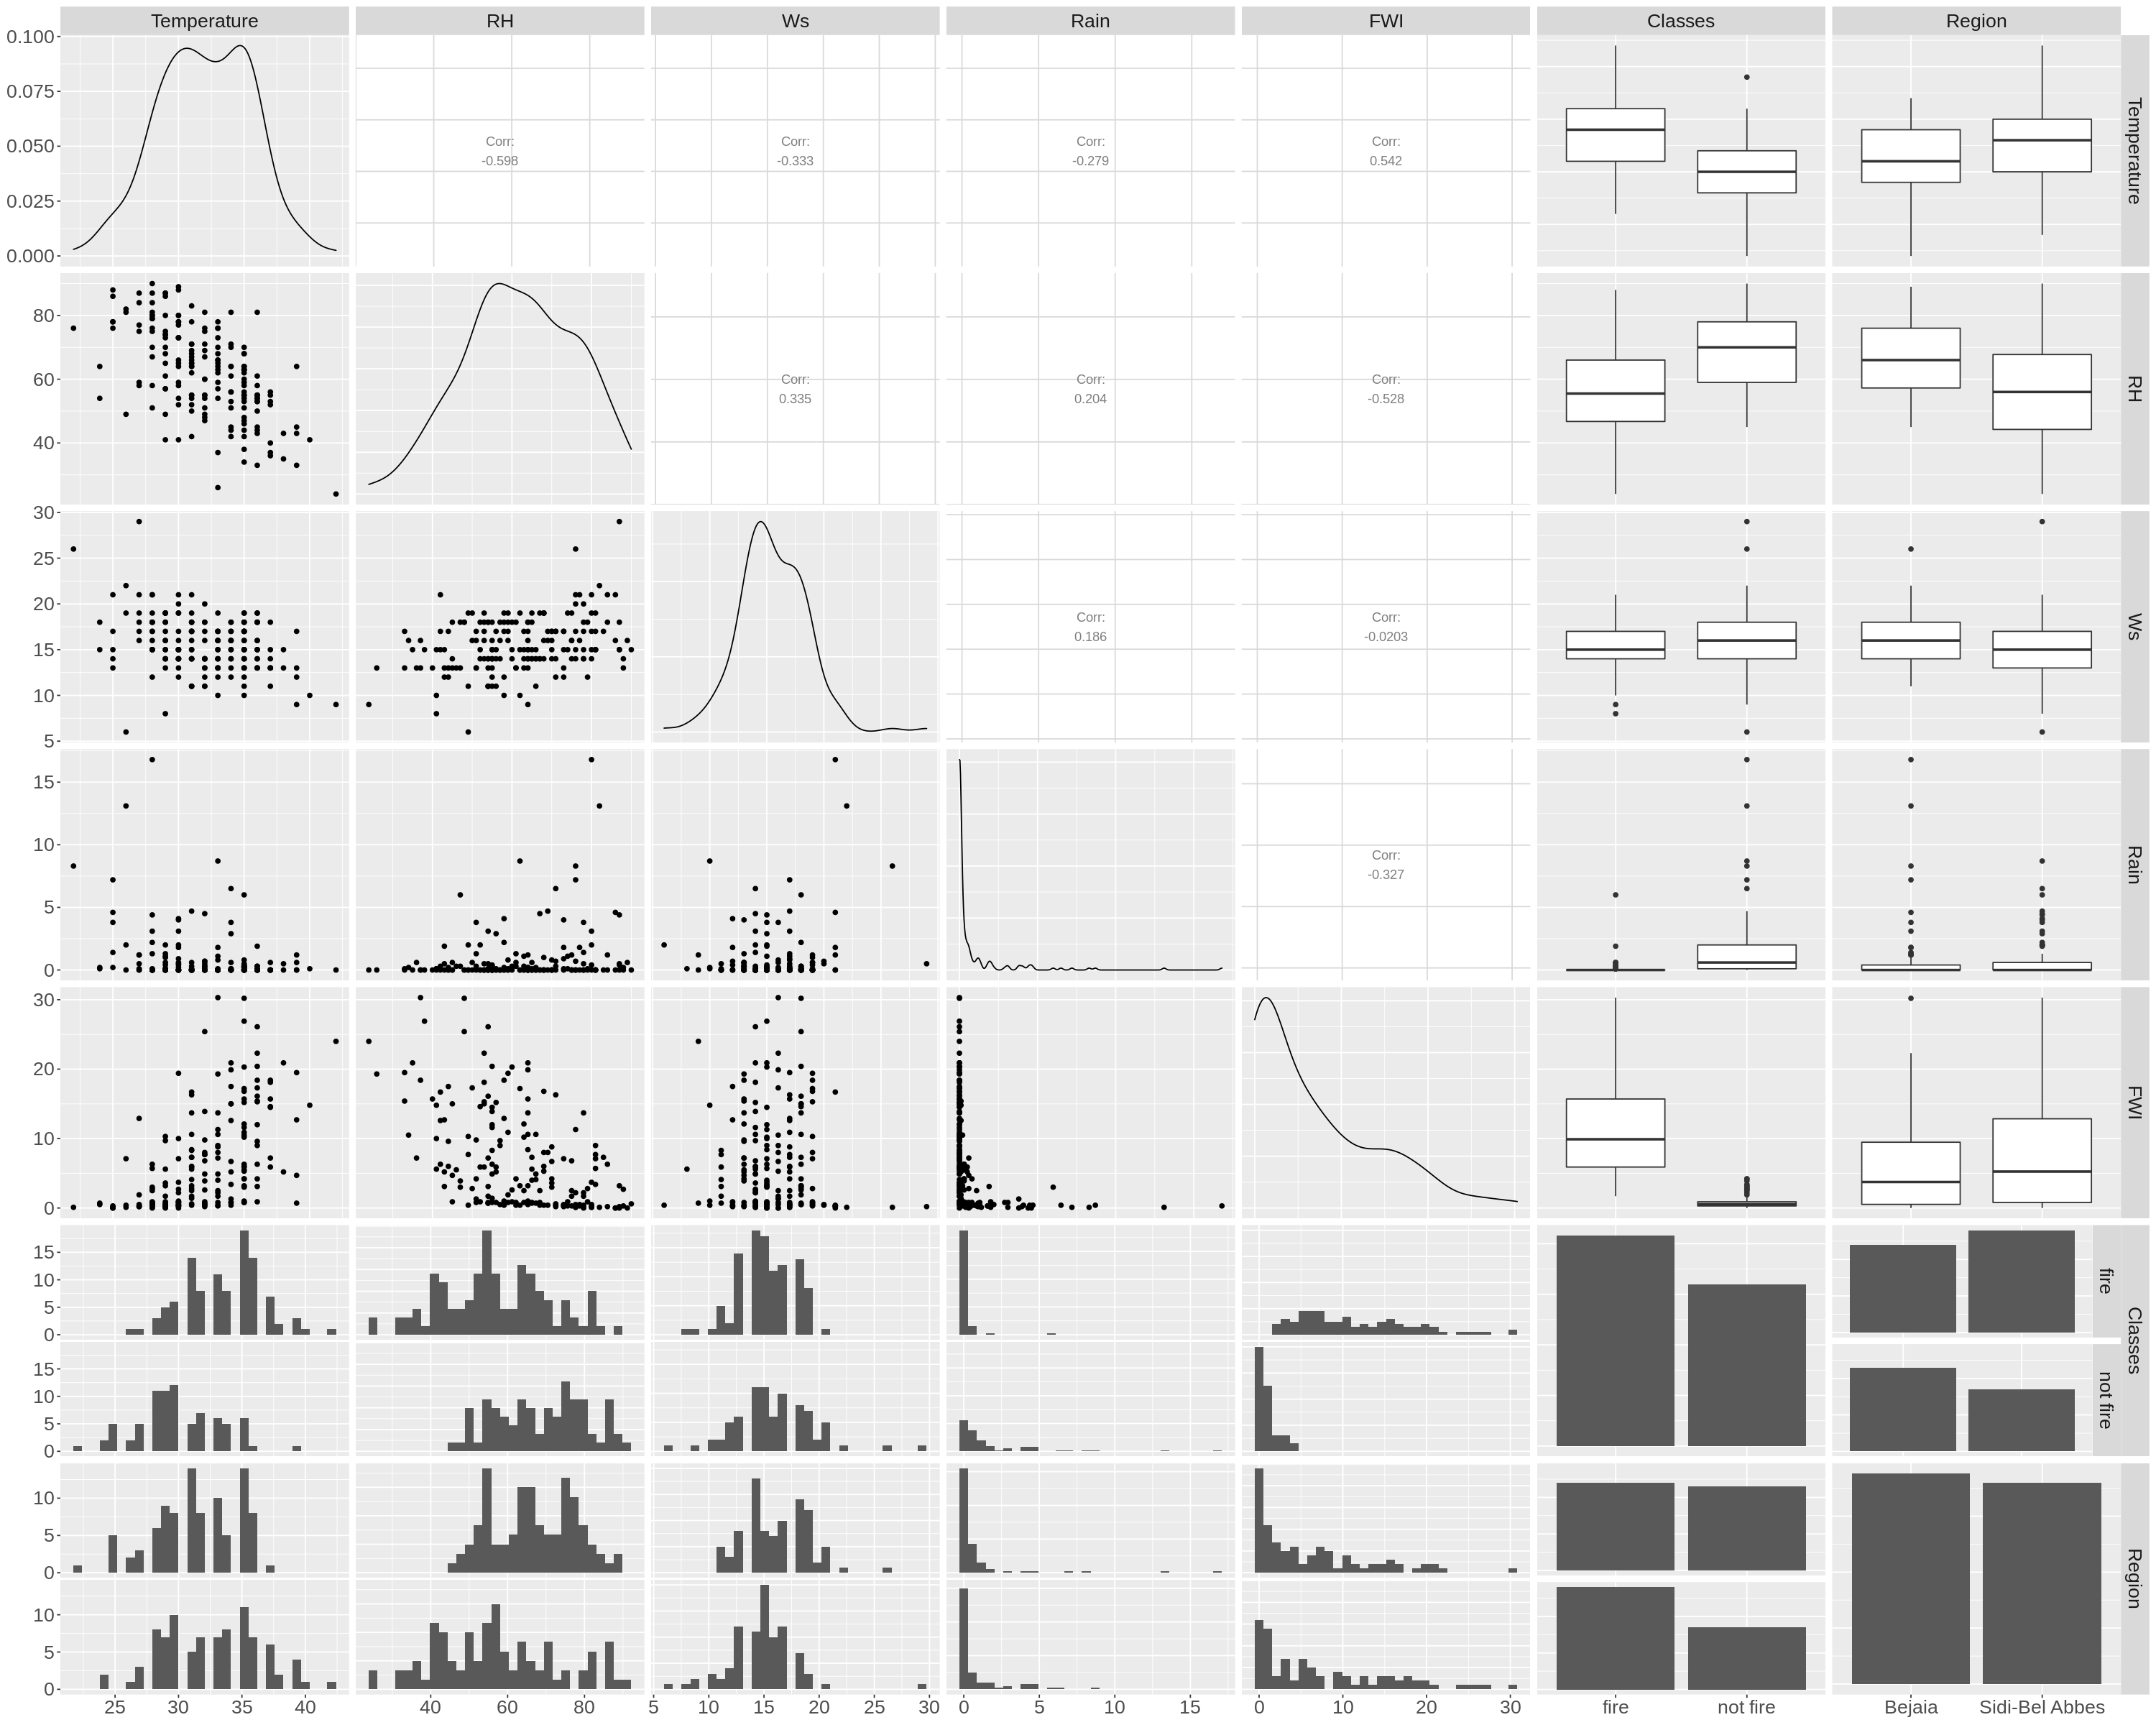

In [64]:
# #preliminary visualization of each of the means based on Paid status and Type
options(repr.plot.height = 20, repr.plot.width = 25)

fire_data_training %>%
    select(-day, -month, -year, -seq, -(FFMC:BUI)) %>%
    ggpairs(axisLabels = "show") +
    theme(text = element_text(size = 20))


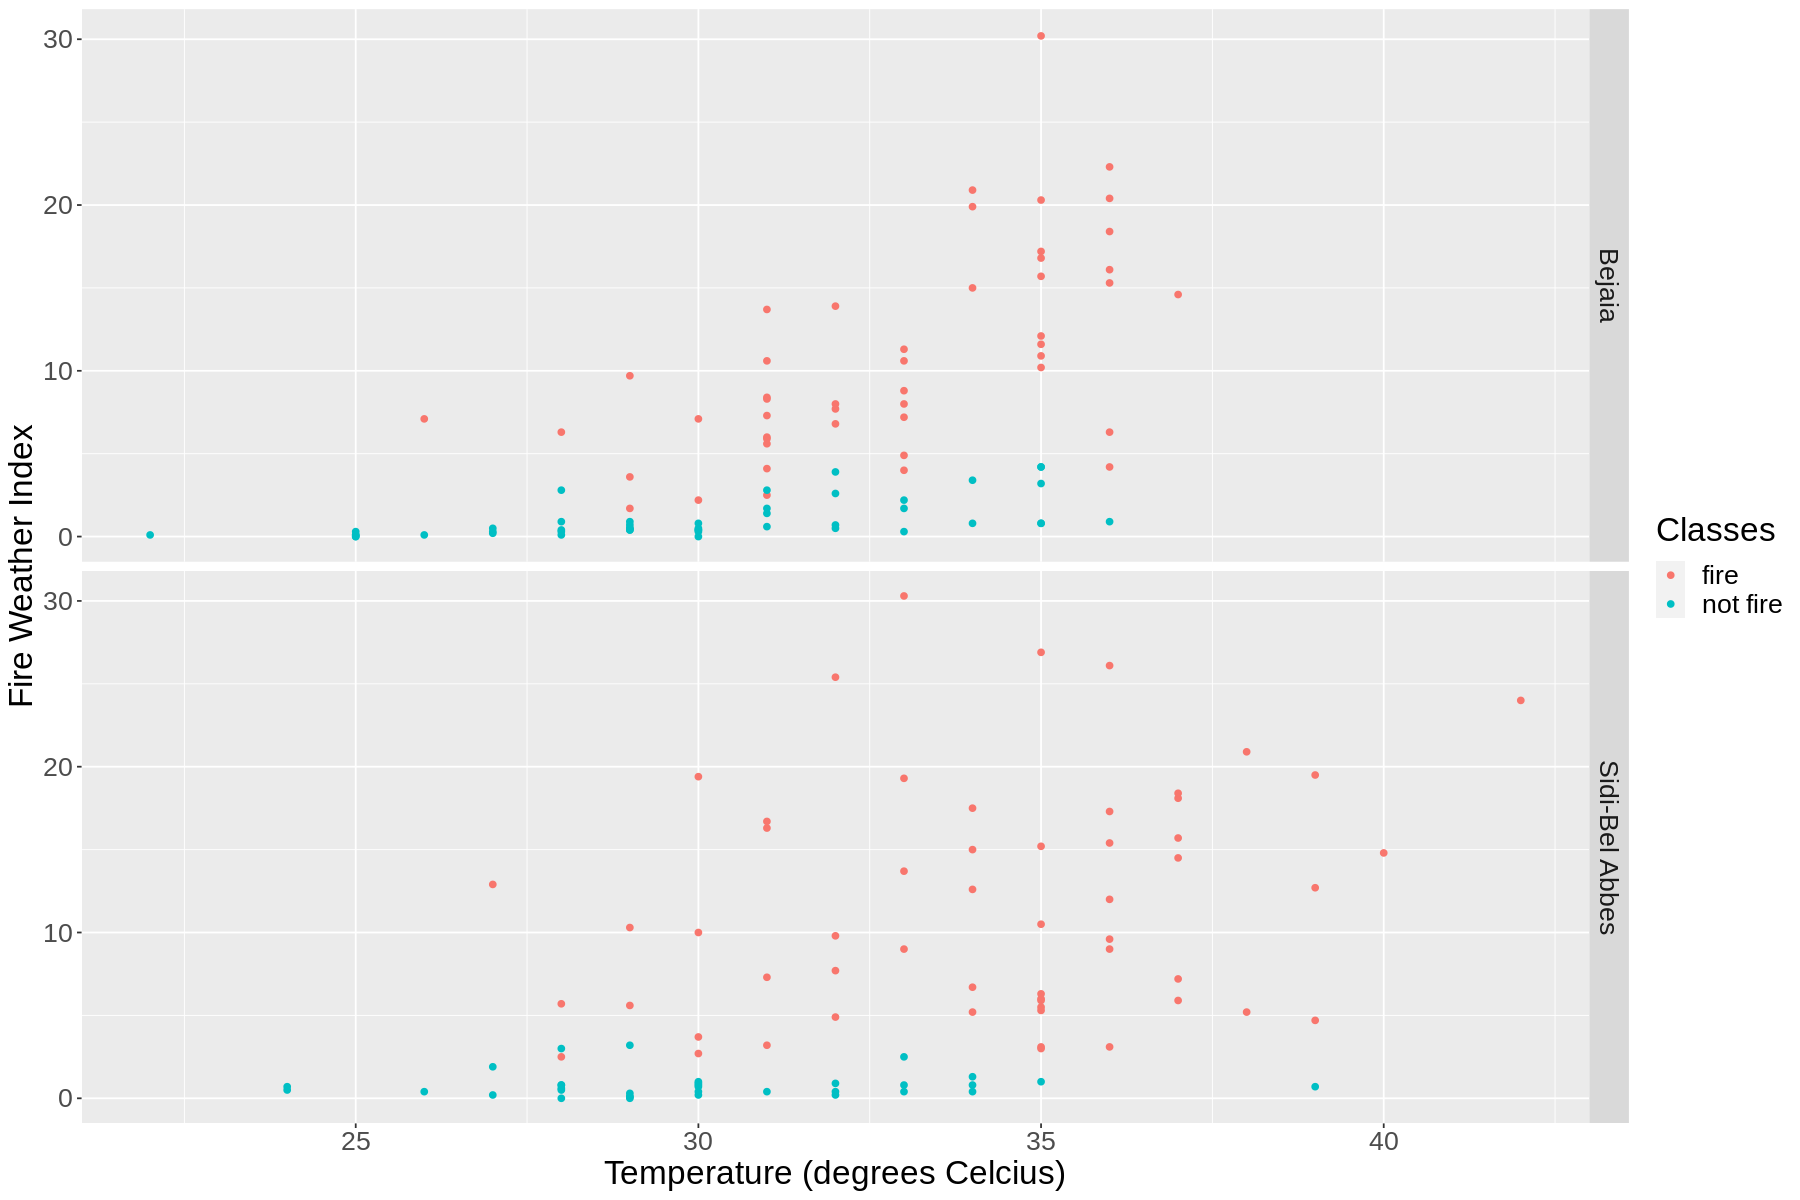

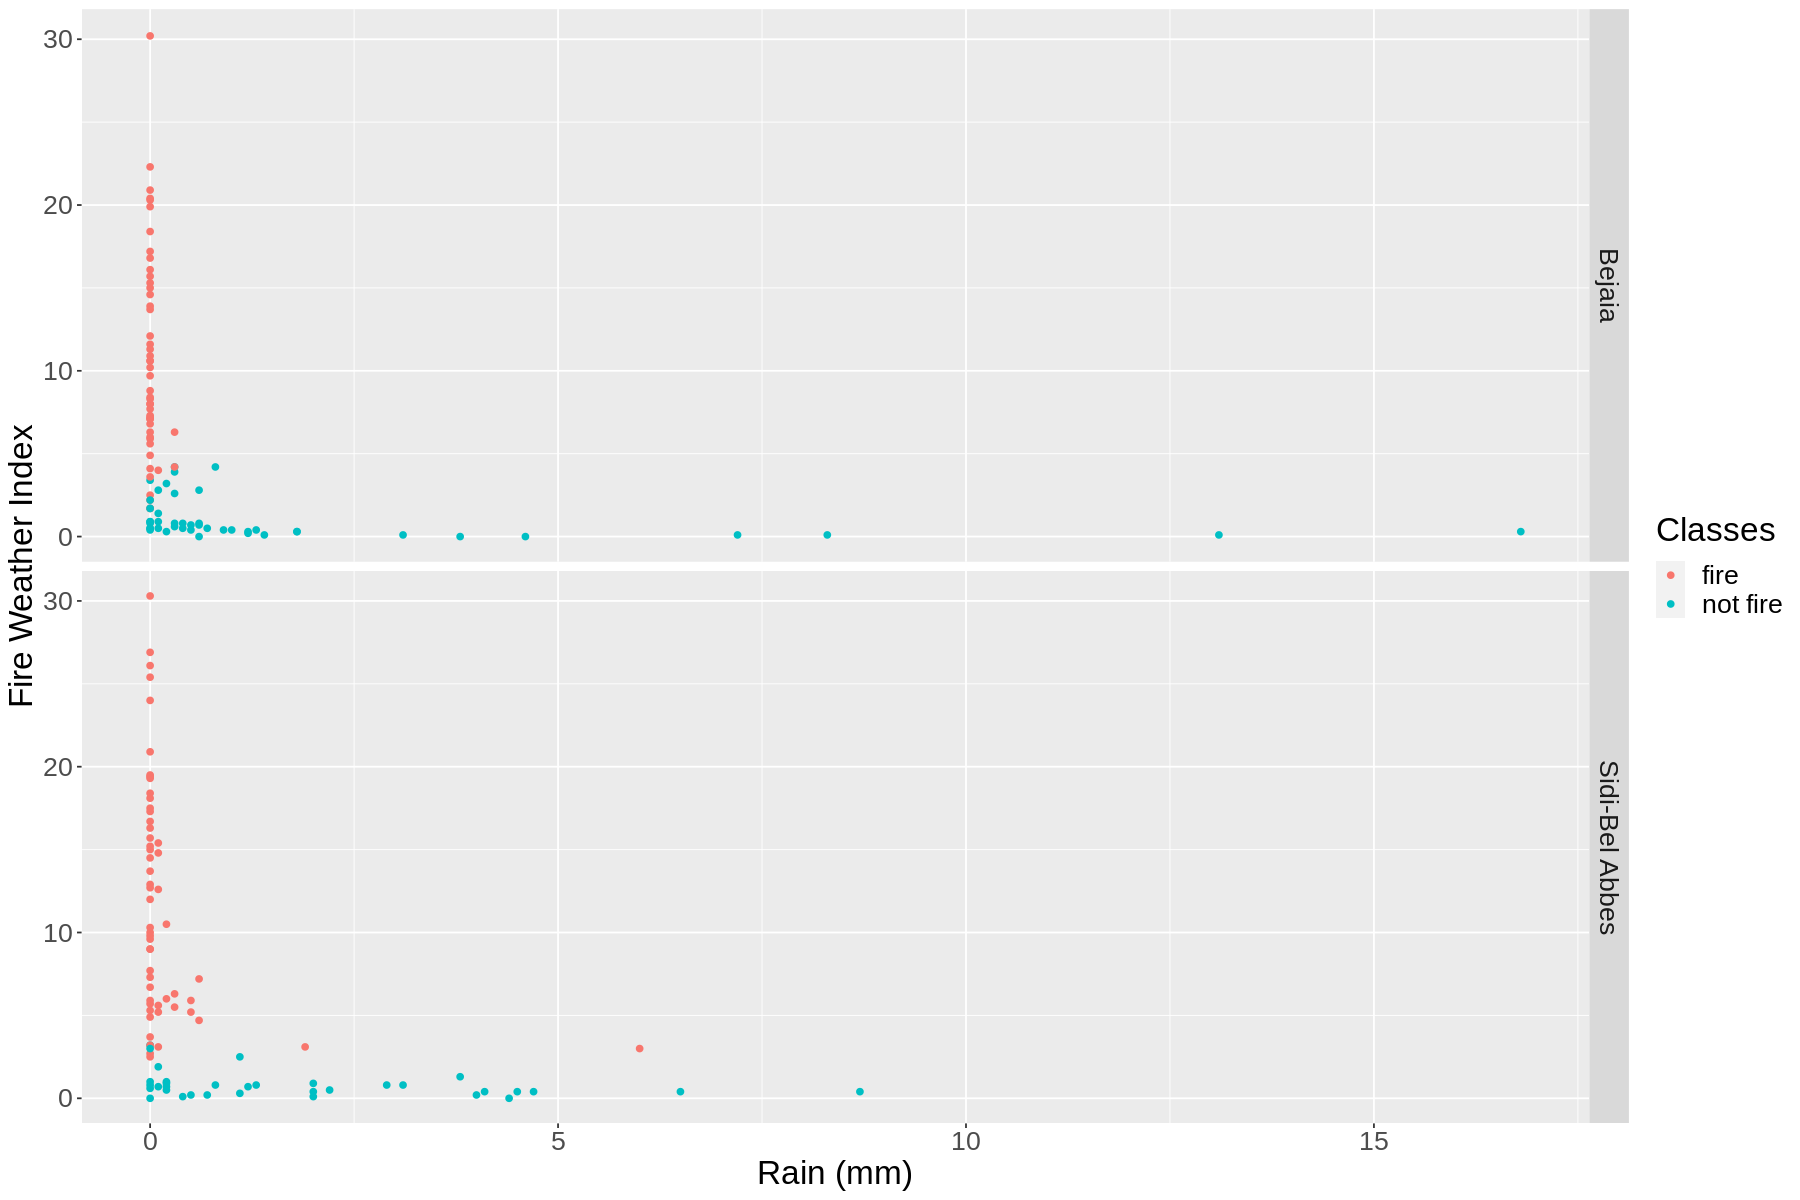

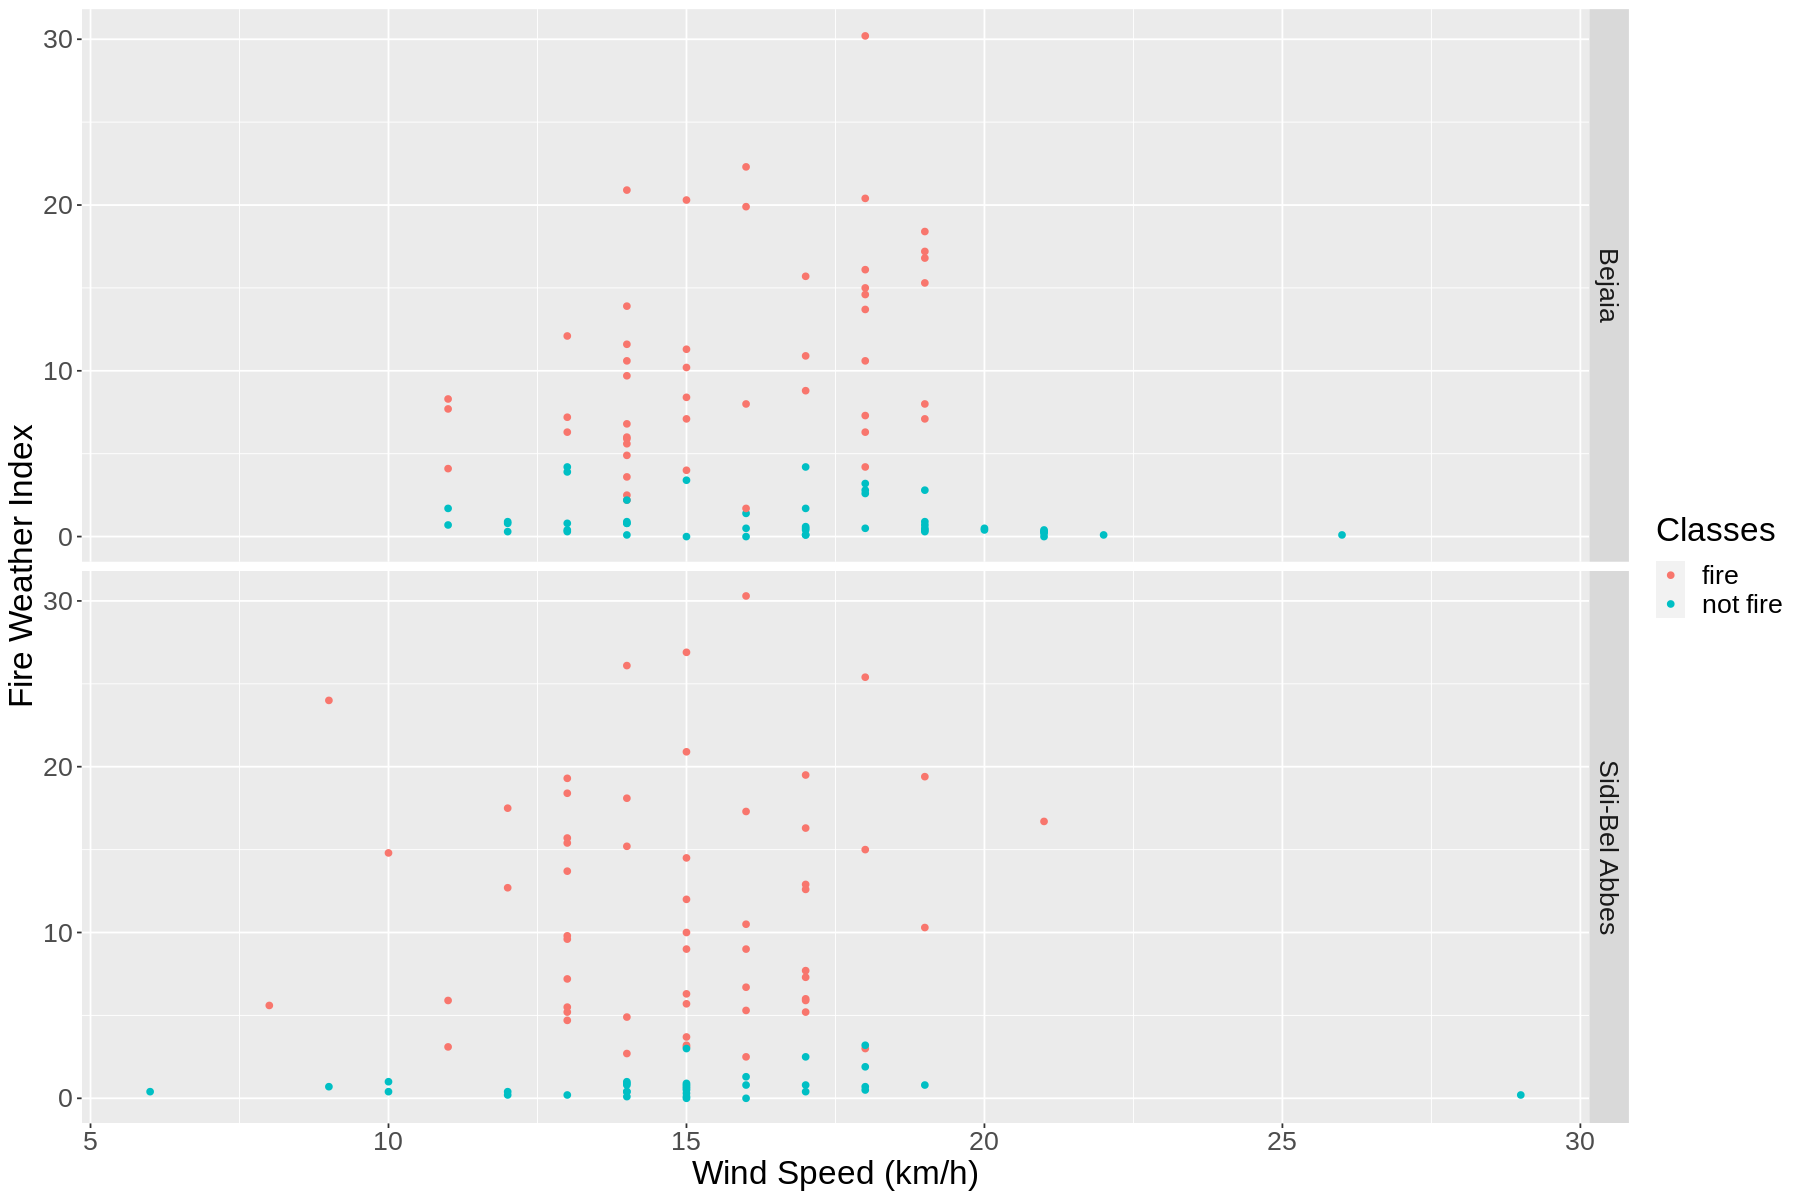

In [65]:
options(repr.plot.height = 10, repr.plot.width = 15)
fire_data_training %>%
    ggplot(aes(x = Temperature, y = FWI)) +
    geom_point(aes(colour = Classes)) +
    xlab("Temperature (degrees Celcius)") +
    ylab("Fire Weather Index") +
    facet_grid(Region~.) +
    theme(text = element_text(size = 20))

fire_data_training %>%
    ggplot(aes(x = Rain, y = FWI)) +
    geom_point(aes(colour = Classes)) +
    xlab("Rain (mm)") +
    ylab("Fire Weather Index") +
    facet_grid(Region~.) +
    theme(text = element_text(size = 20))

fire_data_training %>%
    ggplot(aes(x = Ws, y = FWI)) +
    geom_point(aes(colour = Classes)) +
    xlab("Wind Speed (km/h)") +
    ylab("Fire Weather Index") +
    facet_grid(Region~.) +
    theme(text = element_text(size = 20))

Each plot displays the relation between an observation and the Fire Weather Index, separated by Region and given colours to show the distinction between cases where there was a fire, or there was no fire. 

We can see that when there was a fire, both regions showed a positive linear relation between temperature and Fire Weather index. On the other hand, for both regions, there was also a positive linear relation for when there was no fire, but the strength is much weaker. 

The Fire Weather Index vs Rain plot shows that nearly all of the instances of high Fire Weather Index happens when Rain = 0, for both regions. Furthermore, nearly every instance of Fire occurs when Rain is <1 mm. On the other hand, when there is no fire, we see a wide domain of possible Rain values, with a very limited range of Fire weather indexes. Thus, there is no relation between Fire Weather Index and Rain when there is no fire. 

For the Fire Weather Index vs Wind speed, when there is a fire, there appears to be a very weak positive linear relationship in the Bejaia region, but there is no relation in the Sidi-Bel Abbes region. Furthermore, when the wind speed is very high, there does not seem to be any instances of fires or high Fire Weather Indexes. When there is no fire, we do not see a relationship between Wind speed and Fire Weather Index for both regions.

In [66]:
## Methods